# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['font.size'] = 16
import matplotlib.colors as mcolors

import scipy.constants as ct
import ipywidgets

%matplotlib --list

Available matplotlib backends: ['ipympl', 'osx', 'qt4', 'qt5', 'qt', 'nbagg', 'ps', 'agg', 'svg', 'gtk', 'widget', 'gtk3', 'notebook', 'tk', 'inline', 'pdf', 'wx']


In [35]:
%matplotlib inline

In [73]:
# READ DATA TABLE from text .dat file
tabla = pd.read_table('pos_vel_ppp.dat',index_col=False)

# Rename 'particle' column to 'trajec' and reorder table
tabla.rename(columns={'particle': 'trajec'}, inplace=True)
cols = ['trajec', 'frame', 'x', 'y', 'vx', 'vy']
tabla = tabla[cols]

In [4]:
# Modified table stored into pickle binary format (faster, lighter)
tabla.to_pickle('pppN110.pkl')

In [16]:
# Extract files from 7z compressed format (even lighter)
def extractfiles(zipname):
    system = subprocess.Popen(["7z", "e", zipname])
    return(system.communicate())

In [18]:
# Extract files command
extractfiles('pppN110.7z')

(None, None)

In [26]:
# Read table in pickle format
tabla = pd.read_pickle('pppN110.pkl')


In [117]:
# Last 15 elements, in pickle format
tabla[0:15]

,trajec,frame,x,y,vx,vy
0,0,1,11.167238,12.610994,-0.001627,-0.001911
1,0,2,11.165611,12.609083,-0.001776,-0.001797
2,0,3,11.163685,12.607401,-0.002058,-0.001867
3,0,4,11.161494,12.605349,-0.001820,-0.003029
4,0,5,11.160046,12.601342,-0.001657,-0.003839
5,0,6,11.158181,12.597671,-0.001686,-0.003085
6,0,7,11.156674,12.595173,-0.001451,-0.002352
7,0,8,11.155278,12.592968,-0.002612,-0.002867
8,0,9,11.151451,12.589438,-0.002783,-0.002136
9,0,10,11.149712,12.588696,-0.002744,-0.002464


In [85]:
# NUMBER OF FRAMES and TRACKED TRAJECTORIES SAVED IN THE EXPERIMENT
Nframes = np.max(tabla.frame)
print 'Number of frames:', Nframes
Ntrajec = np.max(tabla.trajec)
print "Number of trajectories:",  Ntrajec

Number of frames: 20001
Number of trajectories: 518


In [144]:
# PHYSICAL SCALES AND ORIGIN
def re_pos_scale(ball):
    
    # COORDINATE ORIGIN: REGION OF INTEREST CENTER (RoI)
    x0 = 0.5 * (np.max(tabla['x']) - np.min(tabla['x'])) + np.min(tabla['x'])
    y0 = 0.5 * (np.max(tabla['y']) - np.min(tabla['y'])) + np.min(tabla['y'])
    if (ball==0):
        # px in mm
        px_size = 0.71
    else:
        # px in ball diameter
        px_size = 54.5

    # physical time. time between frames
    dt = 1/400.
    d = { 'trajec': tabla.trajec, 'frame': tabla.frame, 't': tabla.frame*dt ,'x': tabla.x/px_size, 'y': tabla.y/px_size, 
         'vx': tabla.vx/(dt*px_size), 'vy': tabla.vy/(dt*px_size)}
    rtabla = pd.DataFrame(data = d)
    return rtabla

In [145]:
rtabla = re_pos_scale(0)

In [102]:
### BRIDGE TO VORONOI CODE ###
# BUILD INSTANTANEOUS STATES OF THE SYSTEM

state = [[] for i in range(Nframes)]

def get_state(it, scaled):
    if (scaled == 0):
        st = tabla[ (tabla.frame == it) ]
    else:
        st = rtabla[ (rtabla.frame == it) ]
    # reset row index (otherwise keeps chunks of the original table)
    st = st.reset_index(drop=True)
    cols = ['trajec', 'x', 'y','vx', 'vy']
    st = st[cols]
    return st

def get_xy_from_state(it):
    st = get_state(it)
    cols = ['x','y']
    xy = st[cols]
    return xy

In [146]:
# build instantaneous states over all frames
def get_all_states(Nframes, scaled):
    for i in range(Nframes):
        state[i] = get_state(i,scaled)
        

In [135]:
it = 2

state[it] = get_state(it,0)

In [99]:
# STRUCTURE OF state[it]

state[it]

,trajec,x,y,vx,vy
0,0,15.455600,17.433198,-0.004346,-0.002199
1,1,14.492818,8.471479,-0.001596,-0.006005
2,2,20.002574,8.475141,0.006661,-0.006313
3,3,17.690129,9.081916,-0.006638,0.002602
4,4,24.003062,8.590749,-0.002141,-0.006660
5,5,10.565887,9.031907,-0.001332,-0.000761
6,6,12.717591,7.626989,-0.003640,-0.003583
7,7,21.400938,8.706862,-0.009360,0.003702
8,8,16.739769,7.339530,0.005613,0.001574
9,9,18.670746,7.384095,-0.004441,-0.005375


In [136]:
state[1][1:2]

,trajec,x,y,vx,vy
1,1,10.177911,6.540596,0.001703,-0.004353


In [137]:
state[2][1:2]

,trajec,x,y,vx,vy
1,1,10.179614,6.536243,0.002043,-0.004878


In [142]:
(10.179614-10.177911)/(1/400.)

0.6812000000003593

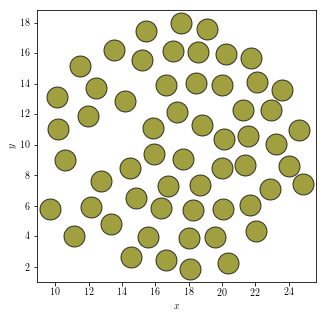

In [100]:
# DRAW INSTANTANEOUS STATE

fig=plt.figure(0, figsize=(5,5))

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(state[it].x, state[it].y, color='olive', s=(21.*72./fig.dpi)**2
            , edgecolors='k', alpha=0.75)

In [147]:
get_all_states(Nframes,1)

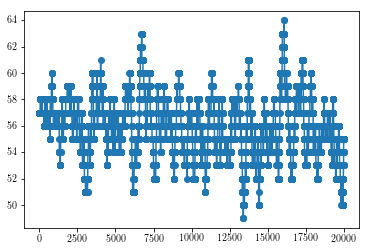

In [119]:
plt.plot([len(state[it]) for it in range(1,Nframes)],marker='o')

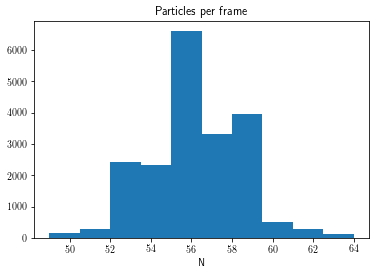

In [120]:
# Number of particles in each frame ROI. Histogram
plt.figure(1)
plt.title('Particles per frame')
plt.xlabel(r'N')
plt.hist([len(state[it]) for it in range(1,Nframes)]);

In [176]:
def del_short_trajec(nf):
    global red_tabla, rNtrajec
    rNtrajec = Ntrajec
    red_tabla = tabla
    for i in range(1,Ntrajec):
        print(len(tabla[(red_tabla.trajec == i)]))
        #if len(tabla[(red_tabla.frame == i)]) < nf:
            #ids = red_tabla[ red_tabla.trajec == 0 ].index
            #red_tabla.drop(ids , inplace=True)
            #rNtrajec = rNtrajec - 1  

In [177]:
del_short_trajec(100)

0
3545
20001
9472
510
5959
6996
20001
13333
4155
1096
4828
559
4682
2955
4409
578
2826
743
1364
4445
2164
3797
312
1293
536
163
1954
11481
6804
10420
6960
140
8681
694
1566
8676
9367
2275
2538
5965
12311
2416
9345
5100
830
10284
191
10757
7315
20001
385
19870
3126
0
8232
20001
20001
245
1076
12317
129
3064
919
2458
202
343
642
64
4547
2146
2825
6770
194
102
1840
736
318
2666
298
2911
610
906
897
1176
396
69
452
1452
359
755
0
8
1978
75
9422
212
5605
430
384
3697
176
434
1269
254
1492
107
495
5685
9076
137
10043
970
15016
94
109
131
572
2794
1282
236
178
14676
1020
3619
15849
115
928
5841
546
16264
1288
256
1303
3543
5114
4737
68
216
182
448
36
5
210
4201
532
516
340
636
109
182
106
5449
1053
0
113
0
188
830
2517
101
2016
407
12907
14040
895
126
0
146
249
87
592
258
458
6454
382
973
502
393
83
869
1154
369
216
4020
4490
6255
160
140
175
148
2891
0
112
0
1810
12
13601
559
1119
9787
181
979
11551
2251
131
6194
342
573
319
256
12731
123
407
12895
1564
604
758
0
695
140
229
881
221
68
10687

In [173]:
Ntrajec

518

In [9]:
# Number of sufficiently long trajectories (length > trajec_length_cut)
Ntrajec

425

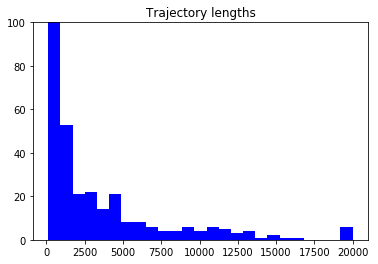

In [172]:
# Histogram of trajectory length
plt.figure(2)
plt.title('Trajectory lengths')
# set upper height limit for histogram
plt.ylim((0,100))
# number of bins
nbins = 25
#plot
plt.hist([len(t[i]) for i in range(Ntrajec)], nbins, color='b');

In [173]:
# Total number of analyzed states (after discard of short trajectories)
np.sum([len(t[i]) for i in range(Ntrajec)])

1113887

In [148]:
# Build array of times where particles trackings are 'lost
t_last = np.zeros(Ntrajec)
for i in range(Ntrajec):
    t_last[i] = t[i][-1]

NameError: name 't' is not defined

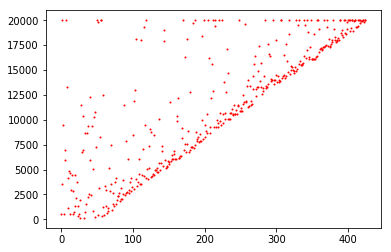

In [175]:
plt.figure(3)
plt.plot(t_last,marker='o',linewidth=0, markersize=1, color='r')

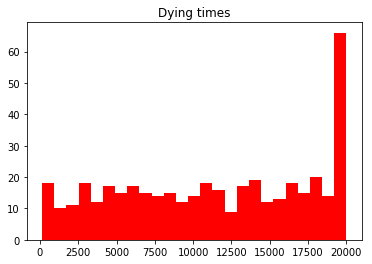

In [176]:
plt.figure(4)
plt.title('Dying times')
#number of bins
nbins = 25
#plot
plt.hist(t_last, nbins, color = 'r');

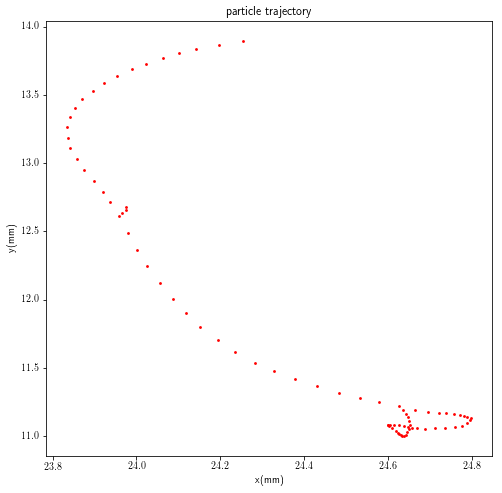

In [17]:
points= plt.figure(5,figsize=(8,8))

#size = 10
jump = 10

i_trajec = 45

plt.title('particle trajectory')
#plt.xlim((-size*0.5,size*0.5))
#plt.ylim((-size*0.5,size*0.5))

plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.scatter(x[i_trajec][::jump], y[i_trajec][::jump], 
            s=8, marker='o', c='r',edgecolors=None,linewidths=0)


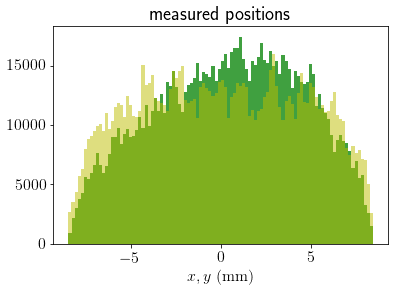

In [30]:
plt.figure(6)
plt.title('measured positions')
plt.xlabel(r'$x, y~\mathrm{(mm)}$')
plt.hist((tabla.x -x0)/px_size, 100, color='g', alpha=0.75);
#plt.figure(3)
plt.hist((tabla.y -y0)/px_size, 100, color='y', alpha=0.5);

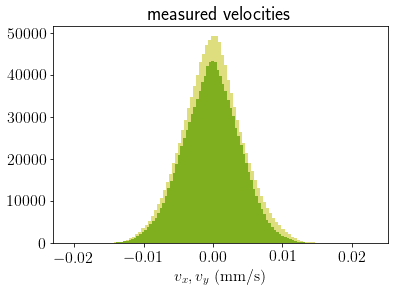

In [29]:
plt.figure(7)
plt.title('measured velocities')
plt.xlabel(r'$v_x, v_y~\mathrm{(mm/s)}$')
plt.hist(tabla['vx']/px_size, 100,color='g',alpha=0.75);
#plt.figure(5)
plt.hist(tabla['vy']/px_size, 100,color='y',alpha=0.5);

In [182]:
# v_x VARIANCE (mm/s^2)
np.var(tabla['vx'])

8.464796097731425e-06

In [183]:
# v_y VARIANCE (mm/s^2)
np.mean(tabla['vy'])

-8.394719251547427e-05